In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D,
SpatialDropout2D, RandomRotation, RandomTranslation, RandomFlip, RandomZoom, GaussianNoise, RandomContrast, RandomBrightness)
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


2025-03-30 14:26:10.030506: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 14:26:10.220640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743366370.289714     452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743366370.312731     452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743366370.481122     452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Sun Mar 30 14:26:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0             12W /   70W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

In [3]:
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

In [4]:
# Define paths
train_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/train'
val_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/val'
test_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test'

# Load datasets
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

print(ds_train.class_names)

# Define augmentation pipeline (applies only during training)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15, fill_mode='reflect'),
    RandomTranslation(0.15, 0.15, fill_mode='reflect'),
    RandomZoom(0.1, fill_mode='reflect'),
    RandomContrast(0.02),  # Reduced from 0.2 → 0.02 (for [0,255] range)
    RandomBrightness(0.02, value_range=(0, 255)),  # Reduced from 0.2 → 0.02
])

# Preprocessing function with augmentation (for training dataset)
def preprocess_image_train(image, label):
    image = tf.cast(image, tf.float32)  # Keep [0, 255] range
    image = data_augmentation(image, training=True)
    image = preprocess_input(image)  # Handles BGR conversion & mean subtraction
    return image, label

# Preprocessing function for validation & test (no augmentation)
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)  # Keep [0, 255]
    image = preprocess_input(image)
    return image, label

# Apply preprocessing & augmentations
ds_train = ds_train.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize dataset performance
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


Found 79999 files belonging to 2 classes.


I0000 00:00:1743366832.551743     452 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 20001 files belonging to 2 classes.
Found 7180 files belonging to 2 classes.
['0_non_cancer', '1_adenocarcinoma']


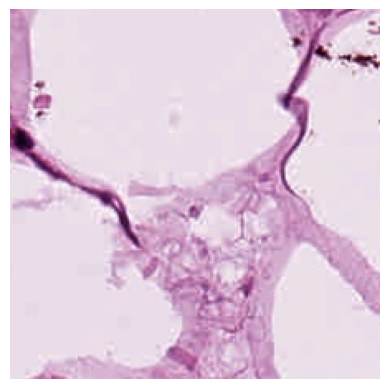

In [5]:
# Sample image
dataset_path = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/train'
class_folders = os.listdir(dataset_path)

sample_img_path = os.path.join(dataset_path, class_folders[0], os.listdir(os.path.join(dataset_path, class_folders[0]))[0])
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# Load VGG16 without the fully connected layers, keep pretrained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 layers so they don’t get updated during training
base_model.trainable = False

# Build custom head with Flatten + BatchNorm
x = base_model.output

# Build the classifier on top
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the new model
model = Model(inputs=base_model.input, outputs=output)

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,270,849 (81.14 MB)

 Trainable params: 6,505,985 (24.82 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

In [7]:
# Define class distribution
class_names = ['0_non_cancer', '1_adenocarcinoma']
num_samples = [68546, 11453]  # Number of samples per class

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # Binary classes: 0 (0_non_cancer), 1 (1_adenocarcinoma)
    y=np.concatenate([np.zeros(num_samples[0]), np.ones(num_samples[1])])  # Labels
)

# Convert to dictionary format for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(0.5835424386543343), 1: np.float64(3.492491050379813)}


In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training if val_loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore best model (avoid last overfitted epoch)
)

In [9]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=2,  # If no improvement for 2 epochs
    min_lr=1e-6  # Don't let it go too low
)

In [10]:
checkpoint_callback = ModelCheckpoint(
    filepath='/mnt/c/Users/vienn/OneDrive/Escritorio/vgg16_model.keras',  # Save path
    monitor='val_loss',        # Track validation loss
    save_best_only=True,       # Save only when val_loss improves
    mode='min',                # 'min' for loss, 'max' for accuracy
)

In [11]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [12]:
history = model.fit(
    ds_train,
    epochs=15,
    validation_data=ds_val,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback]
)

Epoch 1/15


2025-03-30 14:36:34.762166: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1743366995.688948    1877 service.cc:152] XLA service 0x7ff9300157a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743366995.688980    1877 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1743366995.705526    1877 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1743366995.811453    1877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-30 14:36:38.447142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9000 - loss: 1.3159 - precision: 0.6047 - recall: 0.9072

2025-03-30 14:40:30.898686: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng32{k2=2,k6=1,k13=2,k14=0,k22=2} for conv %cudnn-conv-bias-activation.47 = (f16[31,28,28,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,28,28,512]{3,2,1,0} %bitcast.7835, f16[512,3,3,512]{3,2,1,0} %bitcast.7843, f16[512]{0} %bitcast.7846), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/block4_conv2_1/convolution" source_file="/home/axel/myenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-30 14:40:30.906938: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 286s 109ms/step - accuracy: 0.9000 - loss: 1.3158 - precision: 0.6048 - recall: 0.9072 - val_accuracy: 0.9598 - val_loss: 0.6997 - val_precision: 0.7921 - val_recall: 0.9749 - learning_rate: 0.0010
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 278s 111ms/step - accuracy: 0.9426 - loss: 0.7093 - precision: 0.7314 - recall: 0.9456 - val_accuracy: 0.9602 - val_loss: 0.5948 - val_precision: 0.7957 - val_recall: 0.9710 - learning_rate: 0.0010
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 278s 111ms/step - accuracy: 0.9439 - loss: 0.6129 - precision: 0.7353 - recall: 0.9487 - val_accuracy: 0.9696 - val_loss: 0.4906 - val_precision: 0.8679 - val_recall: 0.9291 - learning_rate: 0.0010
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 257s 102ms/step - accuracy: 0.9449 - loss: 0.5748 - precision: 0.7406 - recall: 0.9453 - val_accuracy: 0.9701 - val_loss: 0.5107 - val_precision: 0.8545 - val_recall: 0.9536 - learning_rate: 0.0010
Epoch 5/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 270s 102m

In [13]:
base_model.layers[11].trainable = True
base_model.layers[12].trainable = True
base_model.layers[13].trainable = True

base_model.layers[15].trainable = True
base_model.layers[16].trainable = True
base_model.layers[17].trainable = True

i = 0
for layer in base_model.layers:
    print(f"{i}. {layer.name}: {layer.trainable}")
    i=i+1


0. input_layer_1: False
1. block1_conv1: False
2. block1_conv2: False
3. block1_pool: False
4. block2_conv1: False
5. block2_conv2: False
6. block2_pool: False
7. block3_conv1: False
8. block3_conv2: False
9. block3_conv3: False
10. block3_pool: False
11. block4_conv1: True
12. block4_conv2: True
13. block4_conv3: True
14. block4_pool: False
15. block5_conv1: True
16. block5_conv2: True
17. block5_conv3: True
18. block5_pool: False


In [14]:
early_stopping_fine = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
lr_scheduler_fine = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7
)

In [16]:
from tensorflow.keras.optimizers import SGD
model.compile(
    optimizer = SGD(learning_rate=1e-5, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# Resume training
history_fine = model.fit(
    ds_train,
    epochs=15,  # Fewer epochs for fine-tuning
    validation_data=ds_val,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_fine, lr_scheduler_fine, checkpoint_callback]
)

Epoch 1/15
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9637 - loss: 0.2715 - precision: 0.8130 - recall: 0.9687

2025-03-30 15:54:53.940425: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=4} for conv %cudnn-conv-bw-filter.6 = (f16[512,3,3,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,28,28,256]{3,2,1,0} %bitcast.9883, f16[31,28,28,512]{3,2,1,0} %bitcast.10263), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_1_1/block4_conv1_1/convolution/Conv2DBackpropFilter" source_file="/home/axel/myenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-30 15:54:55.214685: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.274350

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 446s 176ms/step - accuracy: 0.9637 - loss: 0.2715 - precision: 0.8130 - recall: 0.9687 - val_accuracy: 0.9792 - val_loss: 0.2398 - val_precision: 0.8825 - val_recall: 0.9860 - learning_rate: 1.0000e-05
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 374s 149ms/step - accuracy: 0.9700 - loss: 0.2537 - precision: 0.8405 - recall: 0.9744 - val_accuracy: 0.9730 - val_loss: 0.2615 - val_precision: 0.8450 - val_recall: 0.9934 - learning_rate: 1.0000e-05
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 373s 149ms/step - accuracy: 0.9739 - loss: 0.2498 - precision: 0.8591 - recall: 0.9775 - val_accuracy: 0.9848 - val_loss: 0.2239 - val_precision: 0.9140 - val_recall: 0.9867 - learning_rate: 1.0000e-05
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 371s 148ms/step - accuracy: 0.9764 - loss: 0.2419 - precision: 0.8729 - recall: 0.9774 - val_accuracy: 0.9800 - val_loss: 0.2410 - val_precision: 0.8828 - val_recall: 0.9916 - learning_rate: 1.0000e-05
Epoch 5/15
2500/2500 ━━━━━━━━━━━━━━

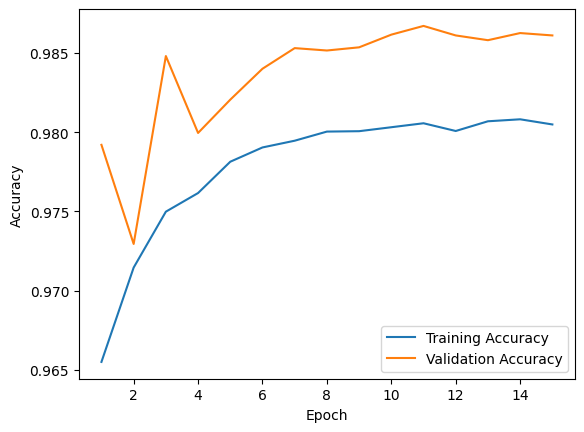

In [17]:
# Model accuracy
accuracy_values = history_fine.history['accuracy']
val_accuracy_values = history_fine.history['val_accuracy']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Accuracy')
plt.plot(epoch, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

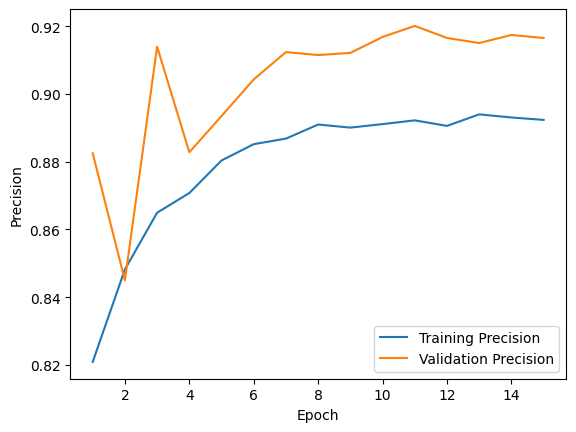

In [18]:
# Model presicion
accuracy_values = history_fine.history['precision']
val_accuracy_values = history_fine.history['val_precision']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Precision')
plt.plot(epoch, val_accuracy_values, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

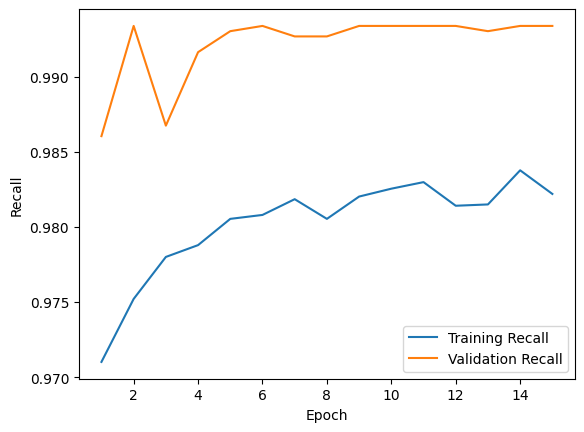

In [19]:
# Model presicion
accuracy_values = history_fine.history['recall']
val_accuracy_values = history_fine.history['val_recall']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Recall')
plt.plot(epoch, val_accuracy_values, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [20]:
best_model = tf.keras.models.load_model('/mnt/c/Users/vienn/OneDrive/Escritorio/Models/VGG16/vgg16_model.keras')

In [21]:
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in ds_val], axis=0)
y_true = y_true.flatten().astype(int)  # Shape: (num_samples,)

# Generate predictions
y_pred_prob = best_model.predict(ds_val).flatten()  # Predicted probabilities
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Binary classes (0 or 1)

# Calculate metrics
f1 = f1_score(y_true, y_pred_class)
bal_acc = balanced_accuracy_score(y_true, y_pred_class)

print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

2025-03-30 17:42:01.935667: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-30 17:42:04.068687: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 244 bytes spill stores, 244 bytes spill loads

2025-03-30 17:42:04.150387: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_229', 4 bytes spill stores, 4 bytes spill loads



626/626 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step
F1 Score: 0.9553
Balanced Accuracy: 0.9895


In [22]:
# Model evaluation
# Get all outputs
results = best_model.evaluate(ds_test)

test_loss, test_acc, test_precision, test_recall = results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9927 - loss: 0.1976 - precision: 0.1352 - recall: 0.1777
Test Loss: 0.2456
Test Accuracy: 0.9769
Test Precision: 0.8990
Test Recall: 0.9749


2025-03-30 17:45:26.656280: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

2025-03-30 17:45:42.753920: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 228 bytes spill stores, 228 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step
Confusion Matrix (Test Set):
 [[5812  135]
 [  31 1202]]


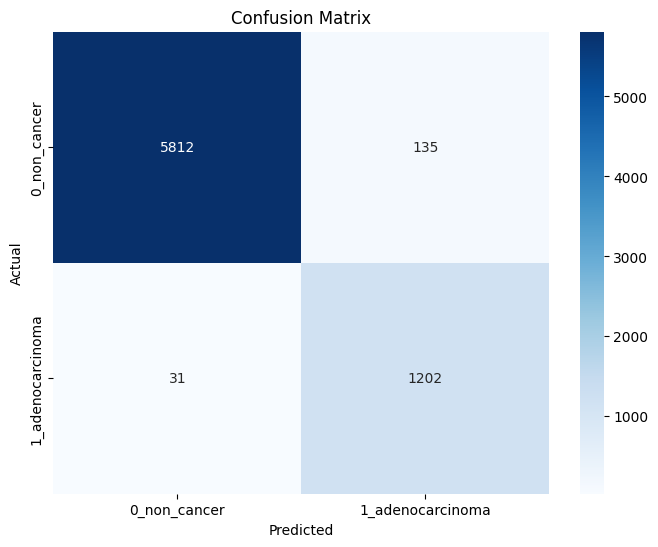

In [23]:
# Get true labels from test dataset
true_labels = np.concatenate([y.numpy() for _, y in ds_test], axis=0)

# Get model predictions
predictions = best_model.predict(ds_test)
predicted_labels = (predictions >= 0.5).astype(int)  # Threshold for binary classification

# Flatten both arrays for confusion matrix
true_labels = true_labels.flatten()
predicted_labels = predicted_labels.flatten()

# Get class names from dataset
class_names = ['0_non_cancer', '1_adenocarcinoma']


# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix (Test Set):\n", cm)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step
Test Recall: 0.9773
Test Precision: 0.8880
Test F1: 0.9305
Confusion Matrix (Test Set):
 [[5795  152]
 [  28 1205]]


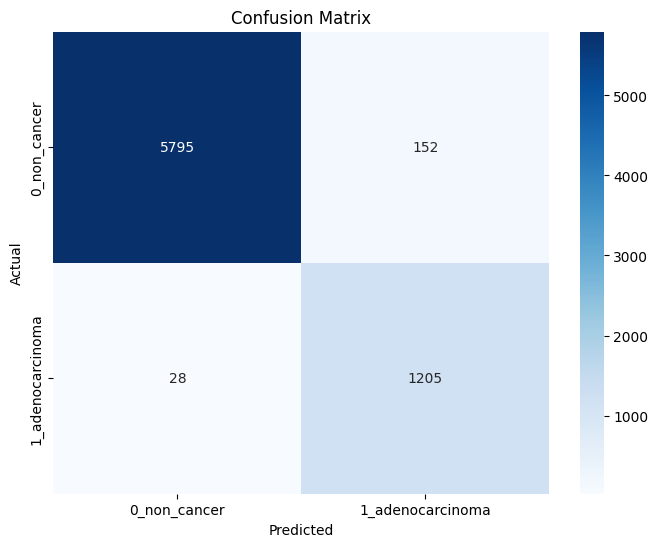

In [27]:
# Predict probabilities for test set
y_pred_prob_test = best_model.predict(ds_test).flatten()

y_true_test = np.concatenate([y.numpy() for _, y in ds_test], axis=0).astype(int)

best_threshold = 0.4
y_pred_class_tuned = (y_pred_prob_test >= best_threshold).astype(int)

# Calculate metrics
from sklearn.metrics import recall_score, precision_score, f1_score

print(f"Test Recall: {recall_score(y_true_test, y_pred_class_tuned):.4f}")
print(f"Test Precision: {precision_score(y_true_test, y_pred_class_tuned):.4f}")
print(f"Test F1: {f1_score(y_true_test, y_pred_class_tuned):.4f}")

# Confusion matrix (optional)
cm = confusion_matrix(y_true_test, y_pred_class_tuned)
print("Confusion Matrix (Test Set):\n", cm)

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_class_tuned)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
def grad_cam(model, img_array, layer_name='block5_conv3'):
    # Create gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # For binary classification (single output node)
        loss = predictions[:, 0]  # Always use index 0 for single output

    # Get gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Pool gradients and create heatmap
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)[0]

    # Post-process heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4):
    # Rescale heatmap to 0-255 and apply colormap
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/axel/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


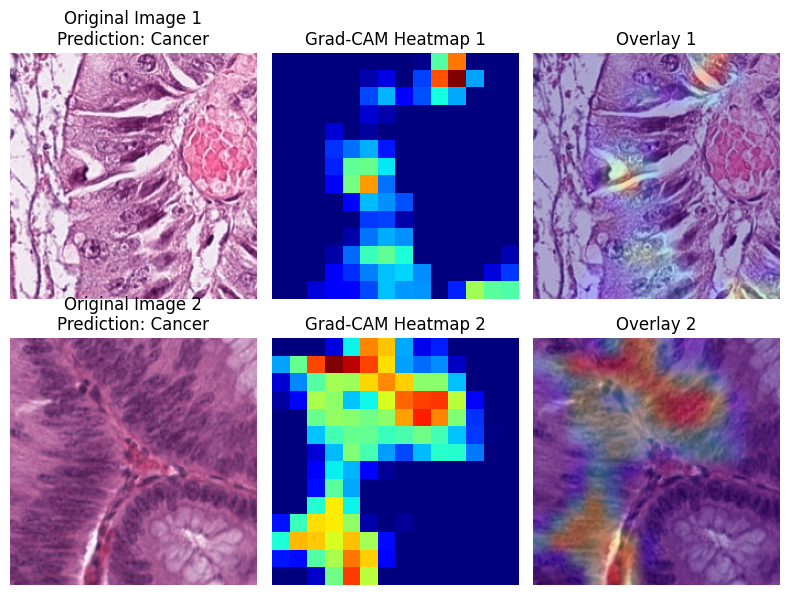

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths to the two images
img_paths = [
    '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test/1_adenocarcinoma/TUM-TCGA-AIHSVASQ.jpg',
    '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test/1_adenocarcinoma/TUM-TCGA-ASNPITVV.jpg'
]

results = []

# Process both images
for img_path in img_paths:
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_processed = preprocess_input(img_array.copy())
    img_array_processed = np.expand_dims(img_array_processed, axis=0)

    # Get prediction
    preds = best_model.predict(img_array_processed)
    pred_class = 1 if preds[0] > 0.5 else 0

    # Generate Grad-CAM heatmap
    heatmap = grad_cam(best_model, img_array_processed)

    # Create overlay
    original_img = img_to_array(img)  # Non-preprocessed image for display
    superimposed_img = overlay_heatmap(original_img, heatmap)

    results.append((original_img, heatmap, superimposed_img, pred_class))

# Plot both images in a 2x3 grid
plt.figure(figsize=(8, 6))  # Adjust figure size for two rows

for i, (orig_img, heatmap, superimposed_img, pred_class) in enumerate(results):
    # Original Image
    plt.subplot(2, 3, 3*i + 1)
    plt.imshow(orig_img / 255.0)
    plt.title(f'Original Image {i+1}\nPrediction: {"Cancer" if pred_class == 1 else "Benign"}')
    plt.axis('off')

    # Heatmap
    plt.subplot(2, 3, 3*i + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f'Grad-CAM Heatmap {i+1}')
    plt.axis('off')

    # Overlay
    plt.subplot(2, 3, 3*i + 3)
    plt.imshow(superimposed_img)
    plt.title(f'Overlay {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()